In [1]:
## ScanPy scRNAseq pipeline without lineage information - recommended by 10x genomics
## Based on Seurat R pipeline (but faster, and Python implementation)
# Following tutorial on the ScanPy website:
# https://nbviewer.jupyter.org/github/theislab/scanpy_usage/blob/master/170505_seurat/seurat.ipynb
# See instructions online: 
# Need ScanPy, MulticoreTSNE (fast implementation of sklearn's t-SNE, 
# https://github.com/DmitryUlyanov/Multicore-TSNE), louvain, and wurlitzer installed
# Must be run on Python 3 - try making Python 3 virtual environment with anaconda:
# https://www.youtube.com/watch?v=Fg-hHwlb2Ik


In [2]:
import sys
sys.version

'3.6.2 |Anaconda, Inc.| (default, Sep 21 2017, 18:29:43) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'

In [3]:
import numpy as np
import scanpy.api as sc
from MulticoreTSNE import MulticoreTSNE as TSNE
import pandas as pd

In [4]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_version_and_date()
# we will soon provide an update with more recent dependencies
sc.logging.print_versions_dependencies_numerics()

Running Scanpy 0.4.3 on 2018-05-17 17:18.
Dependencies: numpy==1.13.1 scipy==0.19.1 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.6.1 


In [5]:
# This is your path to output file
results_file = '/Users/Corey/Documents/BrockLab/outs/write/res_SKMEL5_undiversified_treated.h5ad'

In [6]:
# Reading in 10x data
path = '/Users/Corey/Documents/BrockLab/SKMEL5_undiversified_treated/filtered_gene_bc_matrices/hg19/'
adata = sc.read(path + 'matrix.mtx', cache=True).T  # transpose the data
adata.var_names = pd.read_csv(path + 'genes.tsv', header=None, sep='\t')[1]
adata.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]

... writing an h5ad cache file to speedup reading next time


In [7]:
adata.var_names_make_unique()

In [8]:
# Arbitrary minimum cell and gene values - trying to clean data
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [9]:
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = np.sum(adata.X, axis=1).A1

/Users/Corey/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)


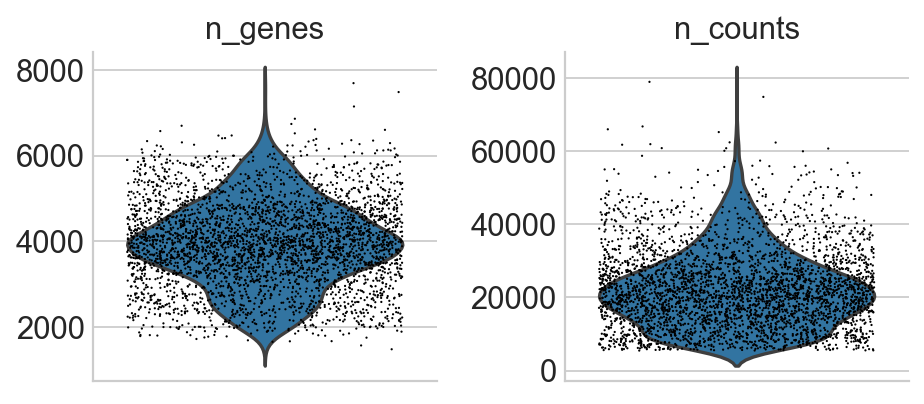

In [10]:
# Get the distribution of genes per cell and cells per gene
axs = sc.pl.violin(adata, ['n_genes', 'n_counts'],
                   jitter=0.4, multi_panel=True)

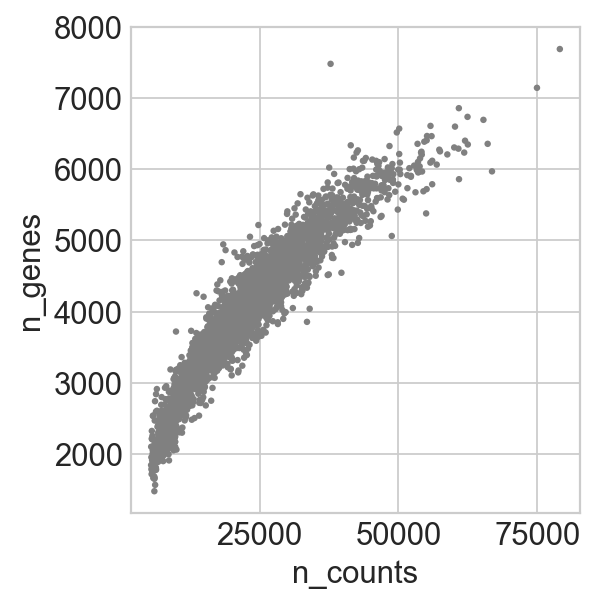

In [11]:
# Look at the pre-normalized comparison of genes per cell and cells per gene
ax = sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [18]:
# Removing high abundance genes - probably for doublets, cell divisions, transcriptional bursting
# adata = adata[adata.obs['n_genes'] < 2500, :]

In [12]:
# Log transform data - minimizes large differences in gene counts
adata_raw = sc.pp.log1p(adata, copy=True)
adata.raw = adata_raw

normalizing by total count per cell
    finished (0:00:00.211): normalized adata.X and added
    'n_counts', counts per cell before normalization (adata.obs)
filter highly variable genes by dispersion and mean (0:00:00.436)
--> set `n_top_genes` to simply select top-scoring genes instead


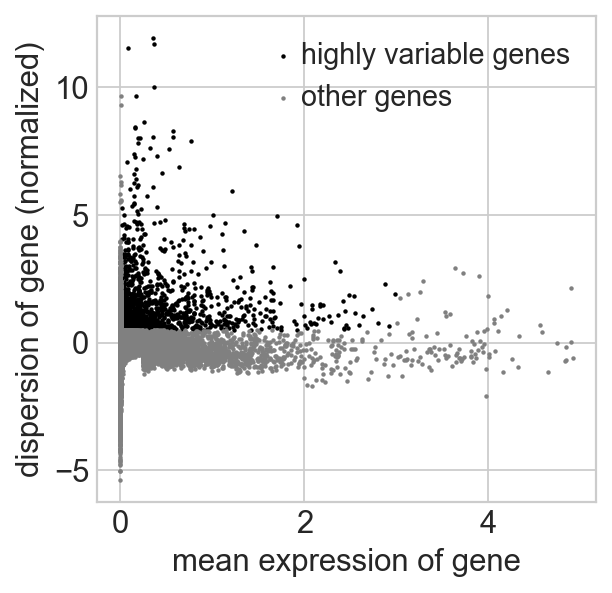

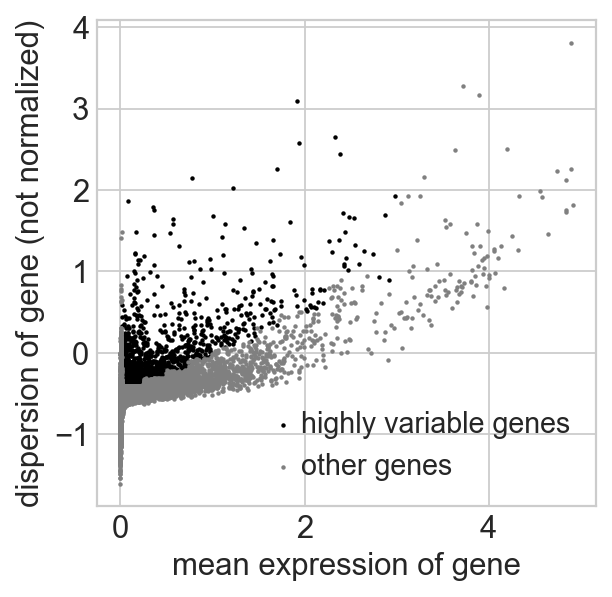

In [13]:
# Normalize genes per cell - see powerpoint for detailed explanation of how I did this
# Filter genes with specific criteria - I did not do this
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

In [14]:
adata = adata[:, filter_result.gene_subset]

In [15]:
sc.pp.log1p(adata)

In [16]:
# Regression of data with cell counts per gene - I did not do this
sc.pp.regress_out(adata, ['n_counts'])

regressing out ['n_counts']
... sparse input is densified and may lead to huge memory consumption


/Users/Corey/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


finished (0:00:06.327)
--> after `sc.pp.regress_out`, consider rescaling the adata using `sc.pp.scale`


In [17]:
# Scale data to specific variance and mean - I did not do this
sc.pp.scale(adata, max_value=10)

In [18]:
adata.write(results_file)

In [19]:
sc.tl.pca(adata)

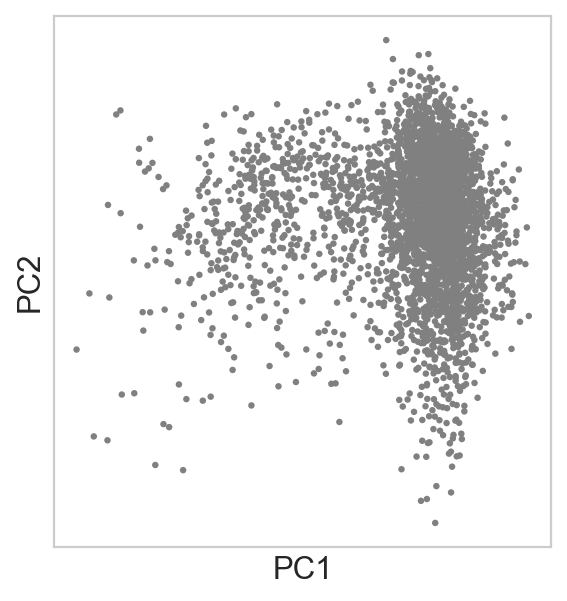

In [20]:
# PCA in 2 dimensions
adata.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat pipeline output
ax = sc.pl.pca_scatter(adata, right_margin=0.2)

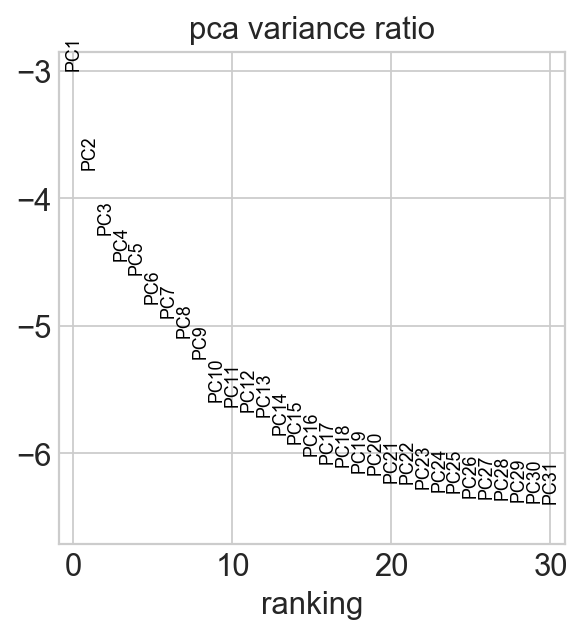

In [21]:
sc.pl.pca_variance_ratio(adata, log=True)

In [22]:
adata = sc.read(results_file)

In [23]:
# PCA with 10 components, then t-SNE in 2 components
# This is seemingly the standard approach
%load_ext wurlitzer
sc.tl.tsne(adata, n_pcs=10, random_state=2)
adata.write(results_file)

computing tSNE
    computing 'X_pca' with n_pcs = 10
--> avoid this by setting n_pcs = 0
    using the "MulticoreTSNE" package by Ulyanov (2017)
    finished (0:00:24.433) --> added
    'X_tsne', tSNE coordinates (adata.obs)


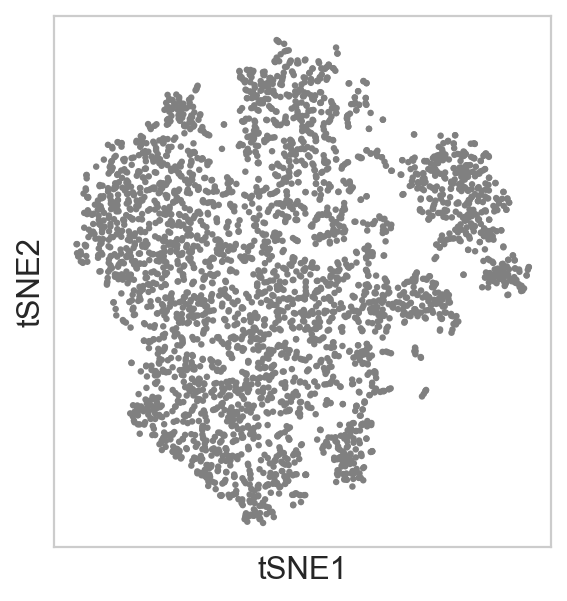

In [24]:
ax = sc.pl.tsne(adata)

In [25]:
# Diffusion maps are a different way to visualize single-cell data (predominately mass cytometry)
sc.tl.diffmap(adata, n_pcs=10)

running Diffusion Maps
    using 'X_pca' with n_pcs = 10 for building graph
    computing data graph with n_neighbors = 30 
    computing spectral decomposition ("diffmap") with 15 components
    eigenvalues of transition matrix
    [ 1.            0.9782766104  0.9316090345  0.9272537231  0.9185595512
      0.8826467991  0.8774657845  0.8736173511  0.8554279208  0.827978313
      0.8114964366  0.8016917109  0.7878624797  0.784599781   0.7759857774]
    finished (0:00:01.329) --> added
    'X_diffmap', tSNE coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)


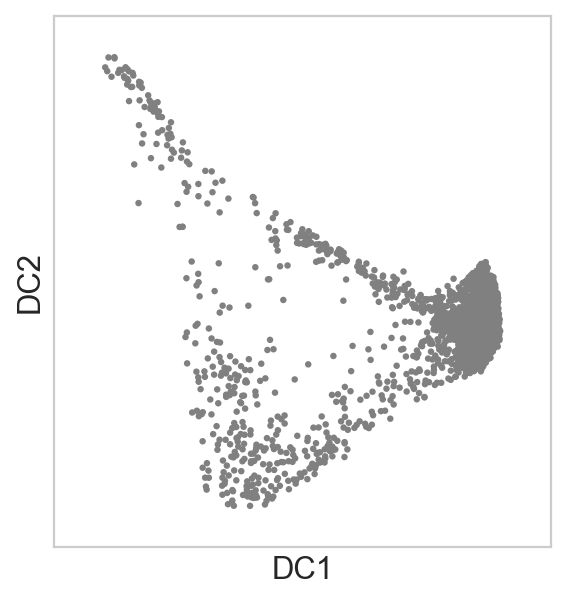

In [26]:
ax2 = sc.pl.diffmap(adata)

In [27]:
adata = sc.read(results_file)

In [28]:
# Louvain clustering - just the clustering approach ScanPy implemented
sc.tl.louvain(adata, n_neighbors=10, resolution=1.3, recompute_graph=True)

running Louvain clustering
    compute 'X_pca' with n_pcs = 50 for building graph
    computing data graph with n_neighbors = 10 
    computing spectral decomposition ("diffmap") with 15 components
    eigenvalues of transition matrix
    [ 1.            0.9850745201  0.9619597793  0.9442958236  0.9346874952
      0.9105926156  0.8994467854  0.8901770115  0.8843083978  0.8632431626
      0.8541849852  0.8392543793  0.8352326155  0.8277618289  0.8203296065]
    using the "louvain" package of Traag (2017)
    finished (0:00:00.964) --> found 15 clusters and added
    'louvain_groups', the cluster labels (adata.obs, dtype=category)


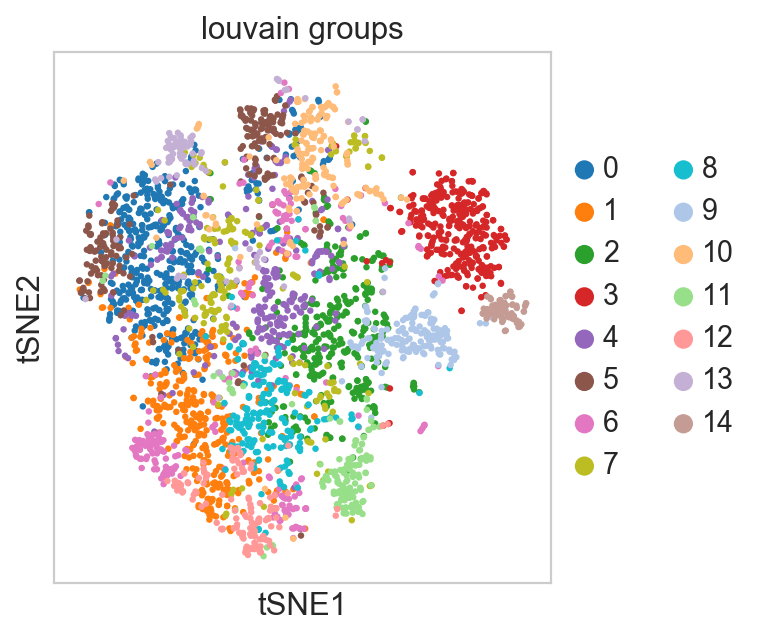

In [29]:
ax = sc.pl.tsne(adata, color='louvain_groups')

In [30]:
adata.write(results_file)